In [1]:
# Install Pyro, if necessary
!pip install pyro-ppl

     |████████████████████████████████| 718 kB 4.3 MB/s 


In [2]:
# imports 
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools
import datetime

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
# defining an error function
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [4]:
# dataset loading
!pip install datapackage

from datapackage import Package

package = Package('https://datahub.io/cryptocurrency/bitcoin/datapackage.json')

# print list of all resources:
print(package.resource_names)

df=[]

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        df=resource.read()
print(df)


     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 68 kB 2.3 MB/s 
     |████████████████████████████████| 72 kB 464 kB/s 
     |████████████████████████████████| 41 kB 449 kB/s 
     |████████████████████████████████| 132 kB 7.9 MB/s 
     |████████████████████████████████| 126 kB 9.9 MB/s 
     |████████████████████████████████| 8.7 MB 7.8 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 127 kB 48.6 MB/s 
  Created wheel for linear-tsv: filename=linear_tsv-1.1.0-py3-none-any.whl size=7400 sha256=86e001e3a6477a9bd3edd8e416ded63b7a24ee0cb9e41fb6d698394cb20680d7
  Stored in directory: /root/.cache/pip/wheels/dd/0a/62/49ee84fab92057fb3e303fb1a59e75ccac6899b417f441305a
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10768 sha256=803c1d1e59308c380063c32e87bcf65f3cdc7fa40b8e9ca50d843bc61c03d029
  Stored in directory: /root/.cache/pip/wheels/1a/f4/8a/a5024fb77b32

In [5]:
# convert to pandas data frame + preprocessing
df=pd.DataFrame(df,columns=['date', 'txVolume(USD)', 'adjustedTxVolume(USD)', 'txCount', 'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)', 'generatedCoins','fees', 'activeAddresses', 'averageDifficulty', 'paymentCount', 'medianTxValue(USD)', 'medianFee','blockSize', 'blockCount'])
df=df[df.date>datetime.date(2013,4,28)]

# get rid of all the half-empty rows, ie. until 2013-04-28, getting rid of first 1571 rows
# df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
# df["txCount"] = pd.to_numeric(df["txCount"])
# df["generatedCoins"] = pd.to_numeric(df["generatedCoins"])
# df["fees"] = pd.to_numeric(df["fees"])
# df["averageDifficulty"] = pd.to_numeric(df["averageDifficulty"])
# df["medianFee"] = pd.to_numeric(df["medianFee"])
# df["medianTxValue(USD)"] = pd.to_numeric(df["medianTxValue(USD)"])
dates = df['date']
no_dates = df.drop('date', axis=1)
no_dates = no_dates.apply(pd.to_numeric,errors='coerce', axis=1)
no_dates_mean = no_dates.mean()
no_dates_std = no_dates.std()
no_dates = (no_dates - no_dates_mean) / no_dates_std
#df=pd.concat([dates,no_dates],axis=1)

# we want to predict the 'price(USD)' value using all other variables (for now)
Y = pd.to_numeric(df['price(USD)'])
X = no_dates.drop('price(USD)', axis=1)
# dropping more columns as a result of feature selection
# X = no_dates.drop('blockCount', axis=1)
# X = X.drop('medianFee', axis=1)

print(Y)


# standardizing 


Y_mean = Y.mean()
Y_std = Y.std()
Y = (Y - Y_mean) / Y_std

y=Y


print(Y)
print(X)

1571     134.44
1572     144.00
1573     139.00
1574     116.38
1575     106.25
         ...   
3600    5559.74
3601    5620.78
3602    4863.93
3603    4465.54
3604    4611.57
Name: price(USD), Length: 2034, dtype: float64
1571   -0.623194
1572   -0.620417
1573   -0.621869
1574   -0.628438
1575   -0.631380
          ...   
3600    0.952342
3601    0.970068
3602    0.750275
3603    0.634580
3604    0.676988
Name: price(USD), Length: 2034, dtype: float64
      txVolume(USD)  adjustedTxVolume(USD)   txCount  marketcap(USD)  \
1571      -0.508095              -0.553943 -1.273419       -0.618150   
1572      -0.513819              -0.549554 -1.318830       -0.616331   
1573      -0.506764              -0.536758 -1.234330       -0.617269   
1574      -0.512054              -0.548859 -1.233029       -0.621546   
1575      -0.516054              -0.550676 -1.276996       -0.623459   
...             ...                    ...       ...             ...   
3600      -0.147208               0.083

In [6]:
# # split into train and test sets
# train_perc = 0.66 # percentage of training data
train_perc = 0.90 # percentage of training data higher to include more recent fluctuations
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X = X.to_numpy()
y = y.to_numpy()
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))



num train: 1830
num test: 204


In [7]:
# train linear
regr = linear_model.LinearRegression()
#regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# # Convert back to the original scale
preds = y_hat * Y_std + Y_mean
y_true = y_test * Y_std + Y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 1.000
MAE: 25.576
RMSE: 37.671
R2: 1.000


In [8]:
# train nonlinear with svr
from sklearn.svm import SVR


kernel="poly"
C=1000
gamma=0.01
epsilon=0.01
degree=3
svrrbf = SVR(kernel=kernel, degree=degree, C=C, gamma=gamma, epsilon=epsilon)
svrrbf.fit(X_train, y_train)
y_hat = svrrbf.predict(X_test)

# # Convert back to the original scale
preds = y_hat * Y_std + Y_mean
y_true = y_test * Y_std + Y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.946
MAE: 238.418
RMSE: 1281.794
R2: 0.869


[  386.54440796   659.00517646 11438.50084083   239.7763886
  6067.78876178  1124.48708166   477.3541586  10322.87142175
   103.94972706   458.19758563   372.08486516   603.28559561
   255.45427448   246.02279007  4527.80503701  8118.77224083
  1865.20286174   227.10455708  4096.21737434   442.77315686
   675.67749309   521.40695933   290.46619505   227.92151025
   620.4049231    265.36798991  6381.36066885   671.05186059
   387.95429952  8480.48216596   264.5646866   7113.92606732
   448.94490148 10522.52803937   454.42168707  4812.50941002
   237.92847804   304.65982538   113.85510376   352.16079963]
[  382.42   578.28 10978.3    236.01  6253.55  1046.08   502.54 10552.6
   104.86   384.64   427.27   637.01   240.3    243.41  4131.98 17527.3
  2043.19   246.17  4089.01   435.13   594.32   571.39   258.55   230.25
   615.69   225.77  6674.08   603.59   437.77  8498.47   226.44  7062.94
   320.43 10287.7    443.88  4200.34   235.97   294.12   105.12   293.14]


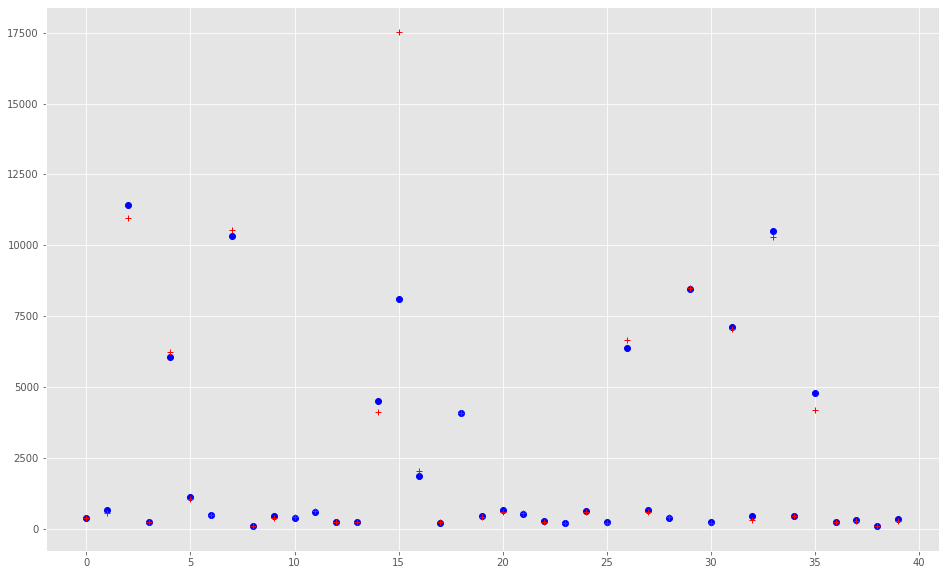

In [9]:
# plot a range
range = 40
plt.plot(preds[:range],'bo')
plt.plot(y_true[:range],'r+')

print(preds[:range])
print(y_true[:range])

In [22]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

print(fs.scores_)


[3.48346732e+03 9.32444817e+03 6.40151982e+02 4.14950206e+06
 1.57407001e+04 9.39520289e+02 6.18951352e+02 1.78627666e+03
 1.72294820e+03 5.30094684e+02 2.36888257e+03 1.65047079e+02
 9.28360376e+02 1.41227653e+01]


In [ ]:
# history of results

# 1
# kernel="poly"
# C=1.0
# gamma='scale'
# epsilon=0.01
# degree=3
# CorrCoef: 0.990
# MAE: 192.225
# RMSE: 474.470
# R2: 0.979

# 2
# kernel="poly"
# C=100
# gamma='scale'
# epsilon=0.01
# degree=3
# CorrCoef: 0.954
# MAE: 169.754
# RMSE: 1021.815
# R2: 0.902

# 3
# kernel="poly"
# C=10
# gamma='scale'
# epsilon=0.01
# degree=3
# CorrCoef: 0.991
# MAE: 130.272
# RMSE: 447.943
# R2: 0.981

# 4
# kernel="poly"
# C=1000
# gamma=0.01
# epsilon=0.01
# degree=3
# CorrCoef: 0.994
# MAE: 147.930
# RMSE: 381.534
# R2: 0.987

# having removed feature 13 and 11 after feature selection

# linear 

# CorrCoef: 1.000
# MAE: 0.000
# RMSE: 0.000
# R2: 1.000
# overtrained ?

# non linear

# kernel="poly"
# C=1000
# gamma='scale'
# epsilon=0.01
# degree=3
# CorrCoef: 0.963
# MAE: 169.089
# RMSE: 963.728
# R2: 0.926

# kernel="poly"
# C=1000
# gamma=0.01
# epsilon=0.01
# degree=3
# CorrCoef: 0.995
# MAE: 159.893
# RMSE: 356.945
# R2: 0.990